In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import joblib

# Налаштування візуалізацій
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 8)

# Завантажуємо денні дані (ті ж, що використовувались для SARIMA)
data_path = '../data/dataset_for_modeling.csv'
df = pd.read_csv(data_path, index_col='DateTime', parse_dates=True)
df_daily = df['Global_active_power'].resample('D').sum()

# Завантажуємо навчену модель SARIMA
sarima_model = joblib.load('../models/sarima_baseline_model.pkl')

# Розділяємо дані
train_data = df_daily.loc[:'2009-12-31']
test_data = df_daily.loc['2010-01-01':]

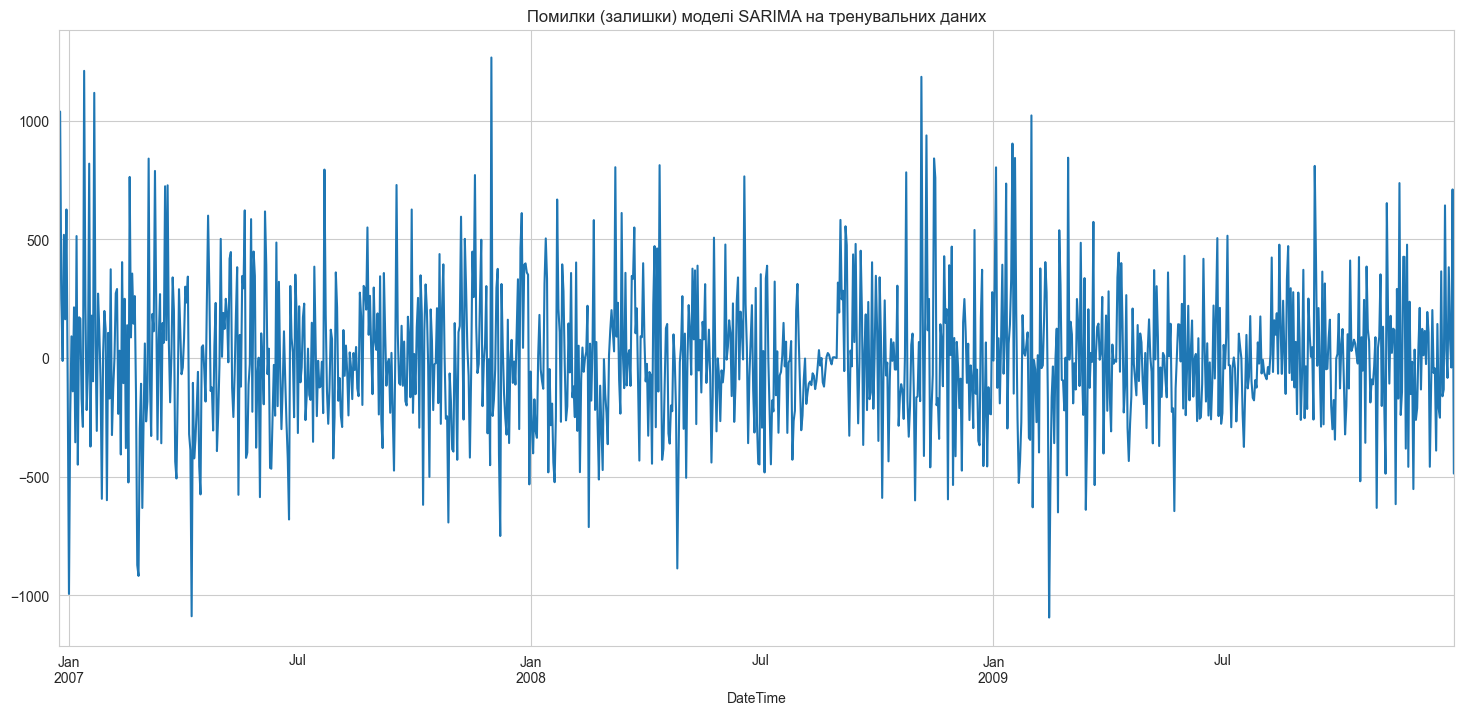

In [2]:
# Отримуємо прогнози SARIMA на тренувальному наборі
# predict_in_sample() робить прогноз для точок, на яких модель навчалась
sarima_train_preds = pd.Series(sarima_model.predict_in_sample(), index=train_data.index)

# Розраховуємо помилки (залишки)
train_residuals = train_data - sarima_train_preds

# Візуалізуємо помилки
train_residuals.plot(title='Помилки (залишки) моделі SARIMA на тренувальних даних')
plt.show()

In [3]:
# Створюємо часові ознаки для X
X_train_residuals = pd.DataFrame(index=train_data.index)
X_train_residuals['day_of_week'] = X_train_residuals.index.dayofweek
X_train_residuals['month'] = X_train_residuals.index.month
X_train_residuals['day_of_year'] = X_train_residuals.index.dayofyear

# Цільова змінна - самі залишки
y_train_residuals = train_residuals

# Навчаємо XGBoost
xgb_residuals_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_residuals_model.fit(X_train_residuals, y_train_residuals)

print("Модель XGBoost для прогнозування залишків навчена.")

Модель XGBoost для прогнозування залишків навчена.


Hybrid Model Mean Absolute Error (MAE): 314.37


/Users/kolya/PycharmProjects/energy_forecast_api/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


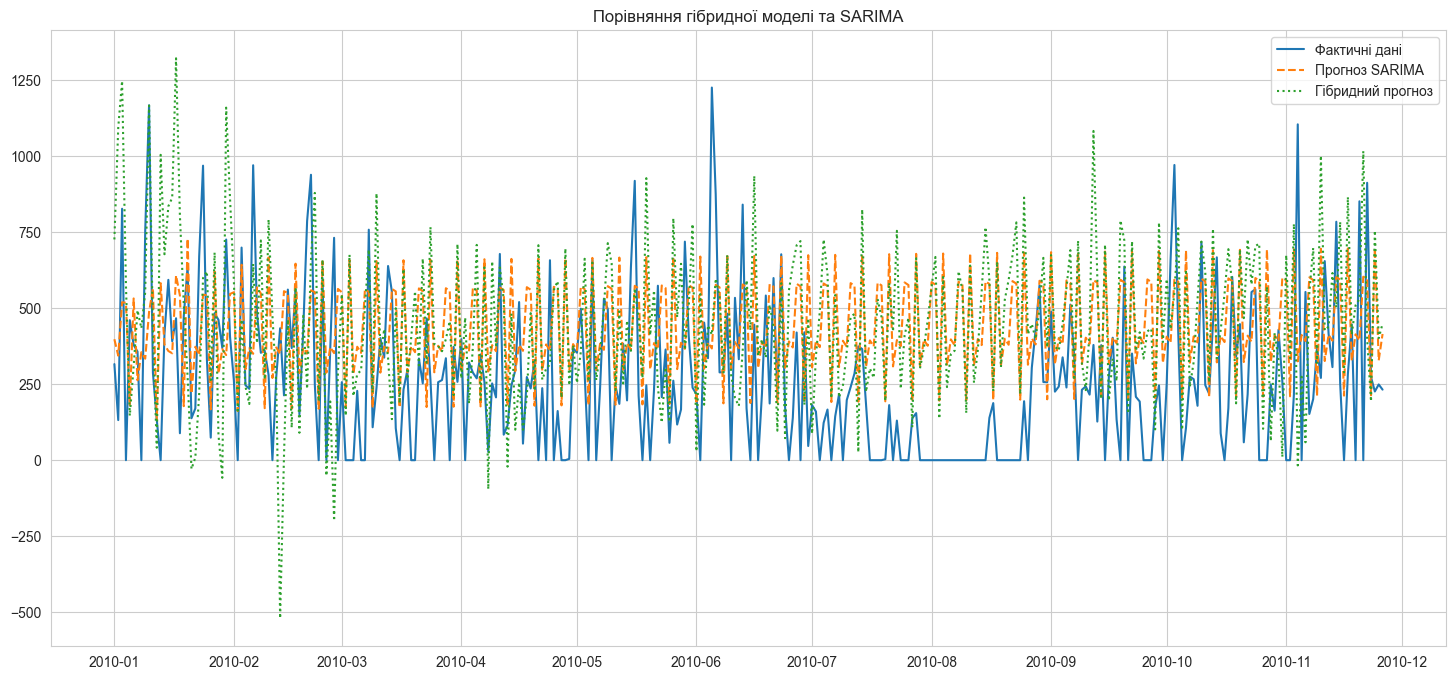

In [4]:
# 1. Отримуємо базовий прогноз SARIMA на тестовий період
sarima_test_preds = pd.Series(sarima_model.predict(n_periods=len(test_data)), index=test_data.index)

# 2. Створюємо ті ж часові ознаки для тестового періоду
X_test_residuals = pd.DataFrame(index=test_data.index)
X_test_residuals['day_of_week'] = X_test_residuals.index.dayofweek
X_test_residuals['month'] = X_test_residuals.index.month
X_test_residuals['day_of_year'] = X_test_residuals.index.dayofyear

# 3. Прогнозуємо помилки за допомогою XGBoost
predicted_residuals = xgb_residuals_model.predict(X_test_residuals)
predicted_residuals = pd.Series(predicted_residuals, index=test_data.index)

# 4. Створюємо фінальний гібридний прогноз
hybrid_preds = sarima_test_preds + predicted_residuals

# Оцінка якості
mae_hybrid = mean_absolute_error(test_data, hybrid_preds)
print(f"Hybrid Model Mean Absolute Error (MAE): {mae_hybrid:.2f}")

# Візуалізація
plt.plot(test_data, label='Фактичні дані')
plt.plot(sarima_test_preds, label='Прогноз SARIMA', linestyle='--')
plt.plot(hybrid_preds, label='Гібридний прогноз', linestyle=':')
plt.title('Порівняння гібридної моделі та SARIMA')
plt.legend()
plt.show()